## TTCT Figural Image Registration

While MOTES Figural will likely not include a paper component, for piloting with TTCT data, we need to extract images of the test responses. First step is image registration, which essentially aligns two images. The intent is to scale and warp each test page to so that they can all be cropped identically.

In [1]:
%load_ext autoreload
%autoreload 2

In [55]:
from pathlib import Path
import pandas as pd
from IPython.display import display
from figural.alignment import *
poppler_path = '/opt/homebrew/bin/'
meta = pd.read_csv('../data/booklet-meta.csv', index_col=0)
path_info = pd.DataFrame([(path.stem, path) for path in Path('../data/ttct_figural').glob('**/*pdf')], columns=['id', 'path'])
meta = meta.merge(path_info)
meta.sample(1)

,id,booklet,titlepage,path
260,75590,BOOKLETB,3,../data/ttct_figural/FS II POST TTCT FRI PMG/7...


Code from: https://learnopencv.com/image-alignment-feature-based-using-opencv-c-python/

Other resources:
- https://pyimagesearch.com/2020/08/31/image-alignment-and-registration-with-opencv/

In [237]:
sample = meta.query('booklet == "BOOKLETA"').sample(2)
sample[['path', 'titlepage']]

,path,titlepage
1225,../data/ttct_figural/TTCT Post ASS SS 2011 E2L...,3
244,../data/ttct_figural/SS 2012 Mills AM-PM Post ...,3


In [75]:
# example of a booklet that doesn't have doublesided pages
sample.loc[1287]

id                                                       68724
booklet                                               BOOKLETA
titlepage                                                    3
path         ../data/ttct_figural/TTCT Post Ass ss2011/6872...
Name: 1287, dtype: object

No alignmentment, using originals


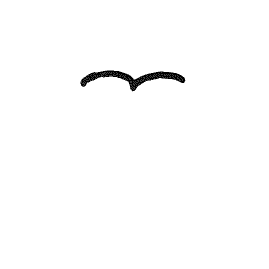

In [404]:
# load booklet A target
target_a = Booklet('../data/blank-bookletA_cleaned.pdf', first_page=2, poppler_path=poppler_path, booklet='a')
target_a.get_activity('2a', mod=10, square=True, use_originals=True)

In [239]:
booklet = Booklet(sample.iloc[0].path, sample.iloc[0].titlepage+1, target_booklet=target_a, poppler_path=poppler_path)

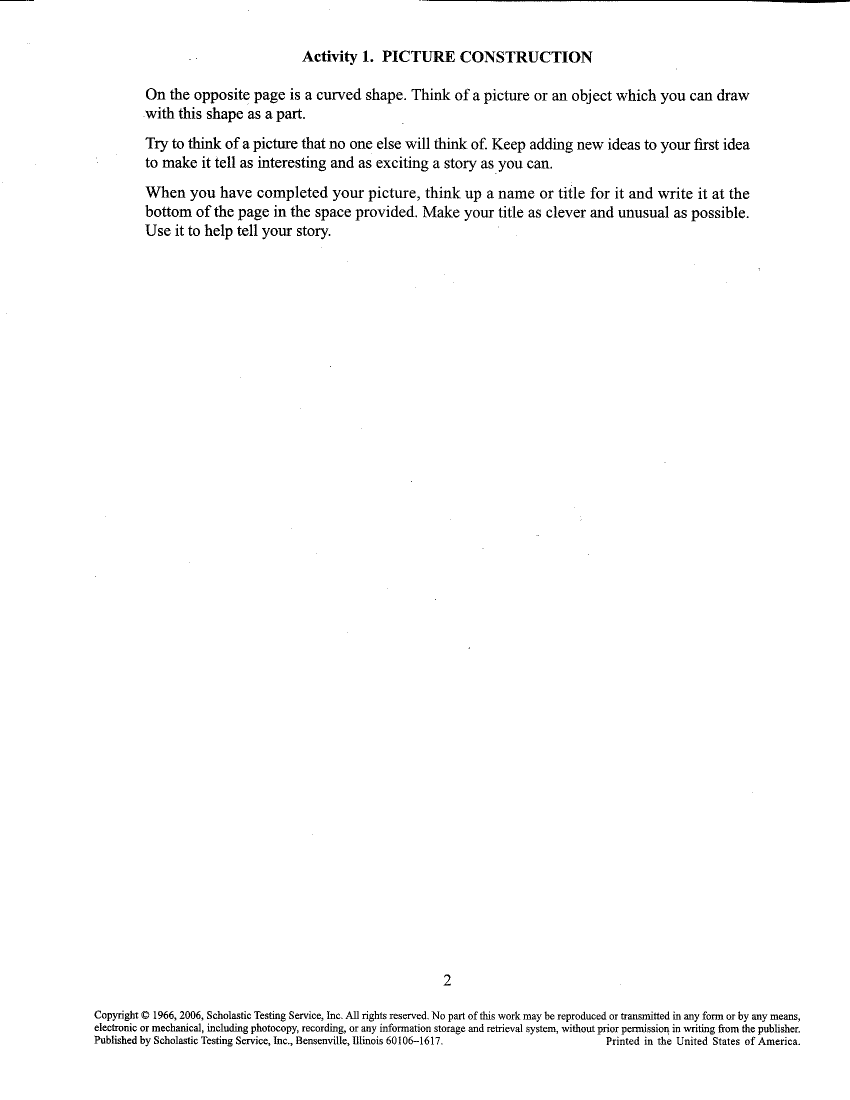

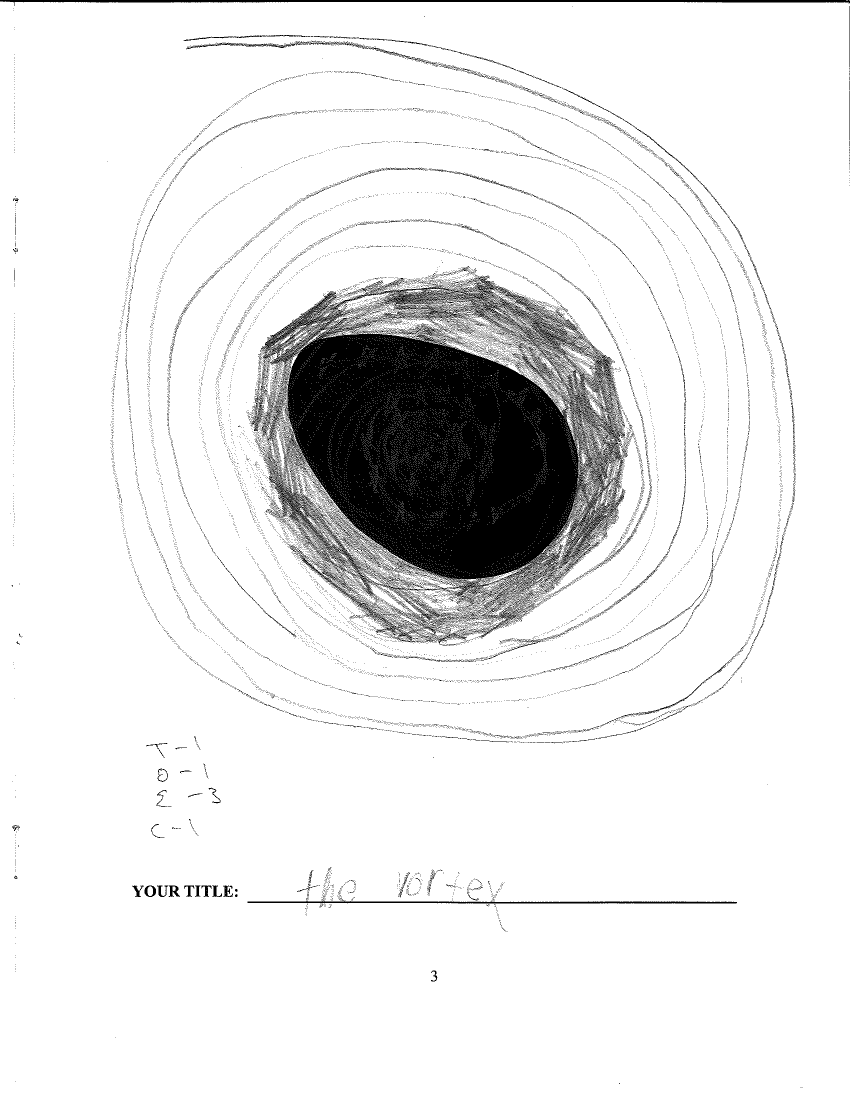

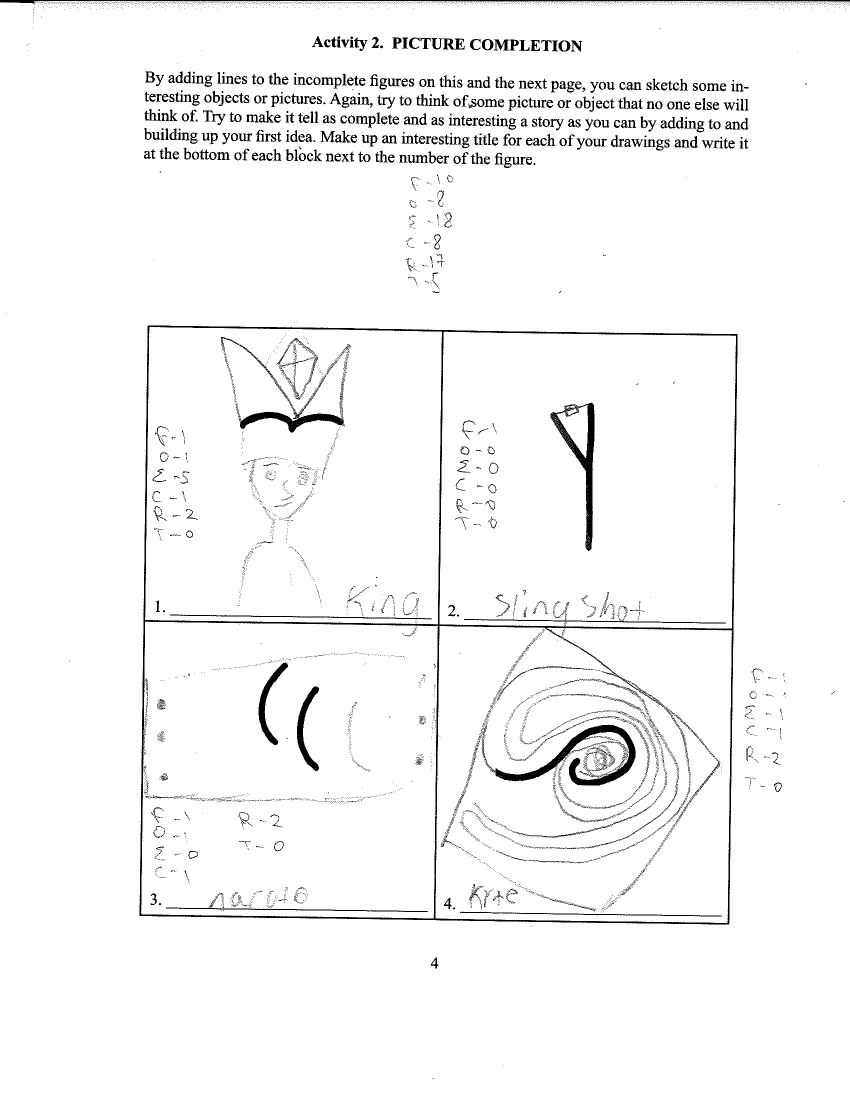

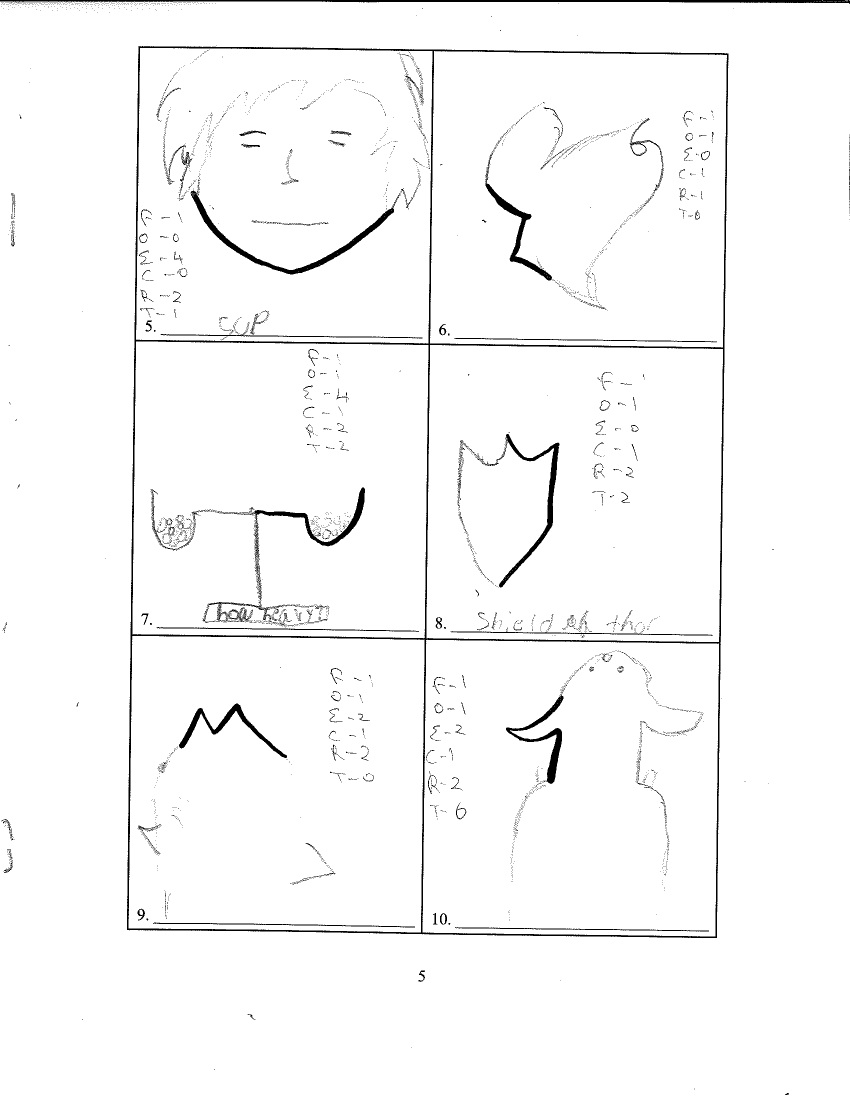

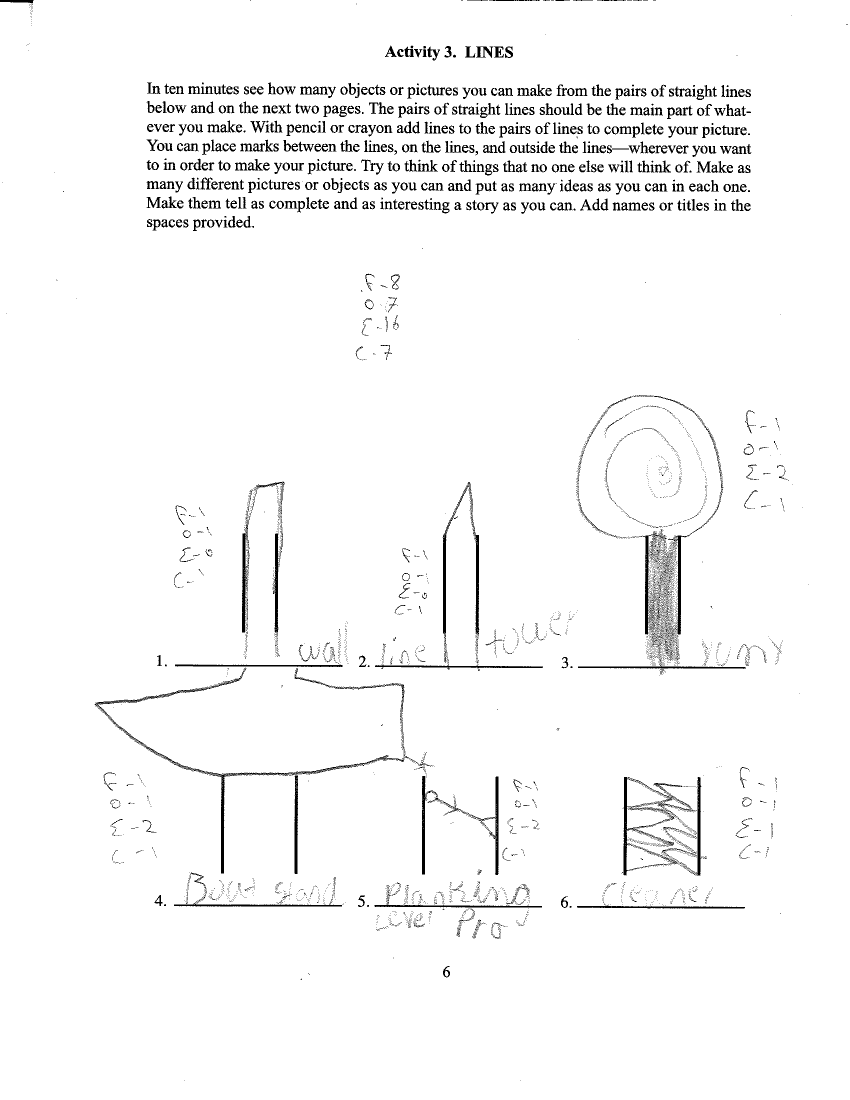

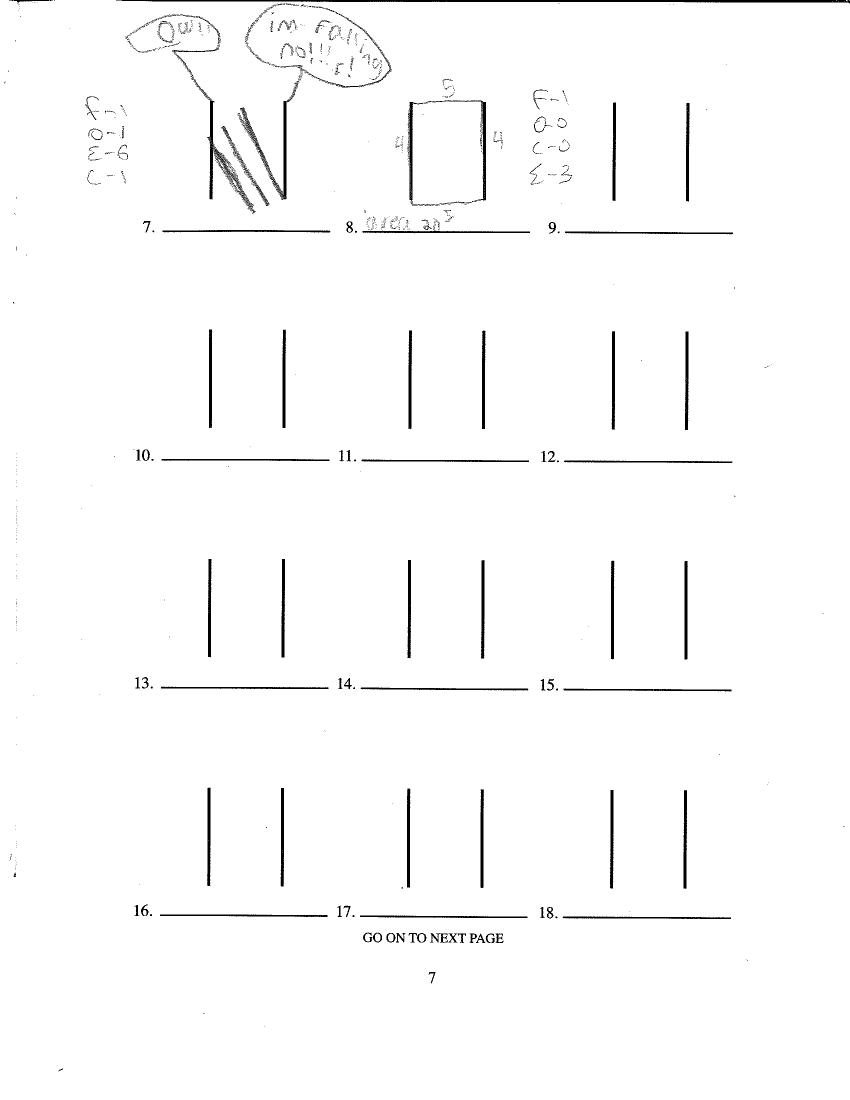

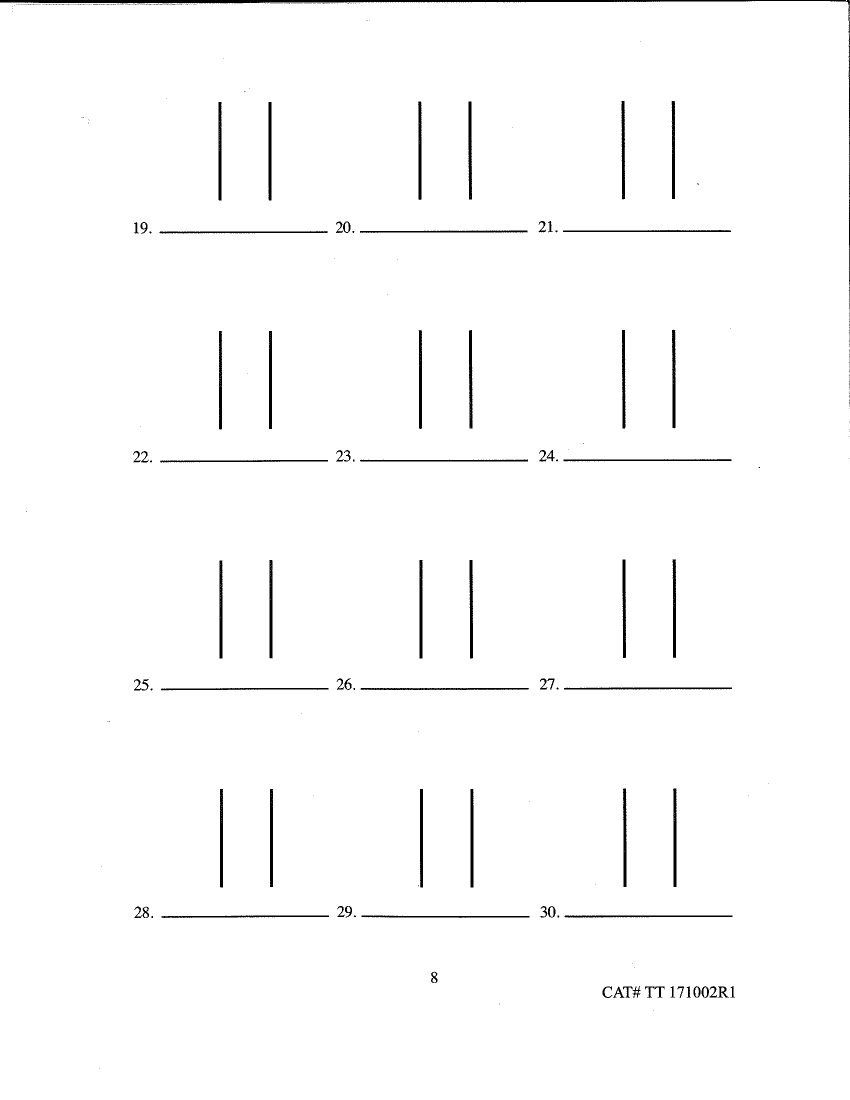

In [215]:
y = booklet.single()
for m in y:
    display(m)

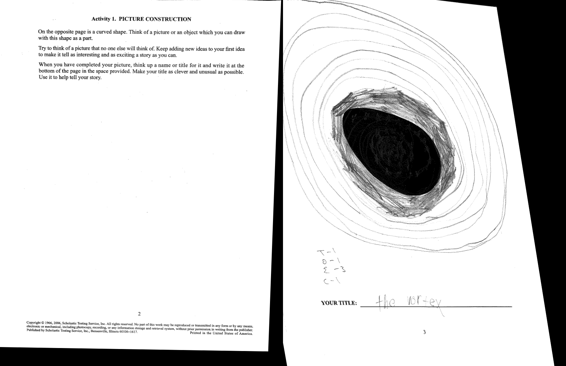

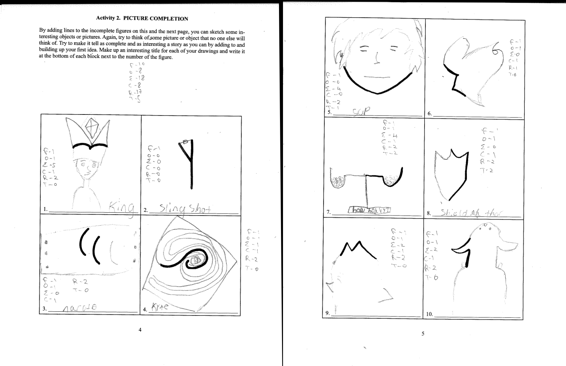

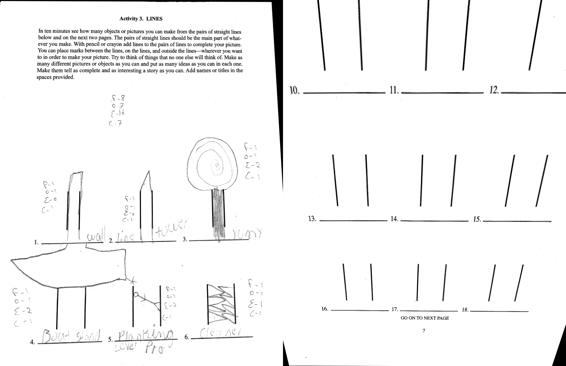

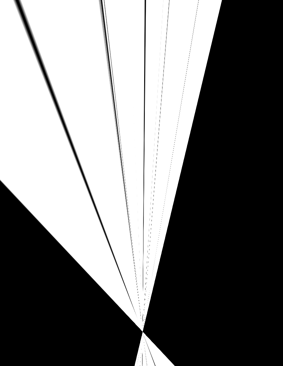

In [219]:
reg, matches = booklet.align(include_matches=True, format="single", good_match_percent=1)
for m in reg:
    w, h = m.size
    display(m.resize((w//3, h//3)))

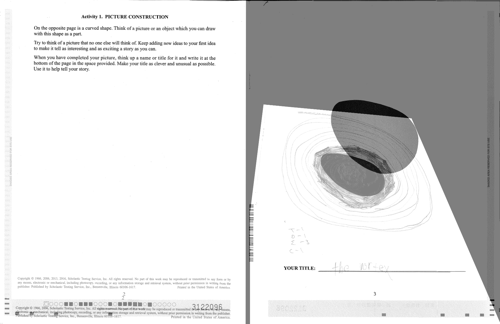

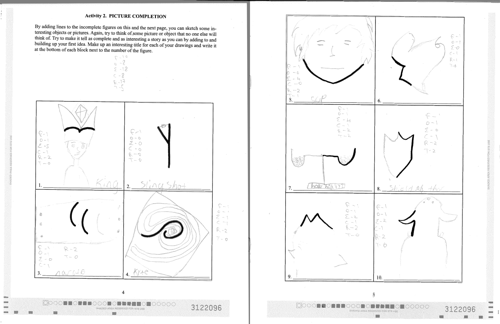

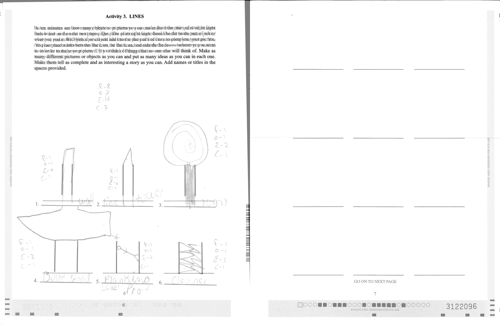

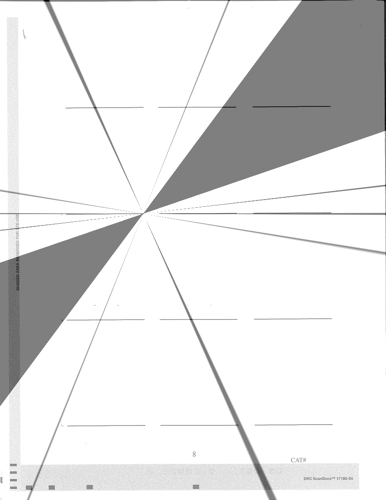

In [212]:
for page in booklet.composite(force=True, format='single', good_match_percent=.25):
    b = page.copy()
    b.thumbnail((500,500))
    display(b)